In [3]:
# This should be roughly the content of the first code cell
import numpy as np
import random
np.random.seed(1337)
random.seed(1337)

# Plotting support
from matplotlib import pyplot as plt
# from plotnine import
# Standard libraries
import pandas as pd
import sklearn as sk
import tensorflow as tf
import time
import os
from skimage import io
import cv2
from scipy import stats
from skimage.util import compare_images
from PIL import Image
from skimage.metrics import mean_squared_error, structural_similarity, hausdorff_distance, normalized_root_mse, peak_signal_noise_ratio
plt.rc('image', cmap='gray')


In [62]:
import SignatureVerificationUtil
def resize_image(image):
    resized_img = cv2.resize(image, (512, 256))
    return np.array(resized_img)

def binarize_images(array):
    temp= np.copy(array)

    super_threshold_indices = temp > 0.8
    temp[ temp != super_threshold_indices] = 1
    temp[super_threshold_indices] = 0
    return temp

def dilate_images(array):
    temp = []
    kernel = np.ones((5,5),np.uint8)

    for image in array:
        dilation = cv2.dilate(image, kernel, iterations=2)
        temp.append(dilation)
    return np.array(temp)

def get_comparison_metrics(image1, image2):
    mse = mean_squared_error(image1, image2)
    ssim = structural_similarity(image1, image2, data_range=1)
    log_and = np.sum(np.logical_and(image1, image2))
    simple_diff = np.sum(np.abs(image1 - image2))

    checkerboard = compare_images(image1, image2, method='checkerboard')
    blend = compare_images(image1, image2, method='blend')
    checkerboard_mean = np.mean(checkerboard)
    blend_mean = np.mean(blend)

    hd = hausdorff_distance(image1, image2)
    nrmse = normalized_root_mse(image1, image2)

    psnr = peak_signal_noise_ratio(image1, image2, data_range=1)

    return [mse, ssim, log_and, simple_diff, checkerboard_mean, blend_mean, hd, nrmse, psnr]


def create_feature_table(curr_genuine, curr_forged):
    # [mse, ssim, log_and, simple_diff, checkerboard_mean, blend_mean, hd, nrmse, psnr]
    feature_table = []

    # curr_genuine = genuine_processed[genuine_labels == 1]
    # curr_forged = forged_processed[forged_labels == 1]

    for i in range(len(curr_genuine)):
        for j in range(i + 1, len(curr_genuine)):
            row = ['label1_gen' + str(i) + '_gen' + str(j)]
            row.extend(get_comparison_metrics(curr_genuine[i], curr_genuine[j]))
            row.append(True)
            feature_table.append(np.array(row))

        for j in range(len(curr_forged)):
            row = ['label1_gen' + str(i) + '_for' + str(j)]
            row.extend(get_comparison_metrics(curr_genuine[i], curr_forged[j]))
            row.append(False)
            feature_table.append(np.array(row))

    feature_table = np.array(feature_table)
    return feature_table

def compare_questioned_against_genuine(curr_genuine, forged):
    feature_table = []
    for i in range(len(curr_genuine)):
        row = get_comparison_metrics(curr_genuine[i], forged)
        feature_table.append(row)
    return np.array(feature_table)

In [10]:
questioned_dirs = os.listdir('ICDAR/Testdata_SigComp2011/SigComp11-Offlinetestset/Dutch/Questioned(1287)')

In [11]:
len(questioned_dirs)

54

In [12]:
reference_dirs = os.listdir('ICDAR/Testdata_SigComp2011/SigComp11-Offlinetestset/Dutch/Reference(646)')

In [13]:
len(reference_dirs)

54

## Focusing of dirrectory 013 for now

In [18]:
questioned_13 = os.listdir('ICDAR/Testdata_SigComp2011/SigComp11-Offlinetestset/Dutch/Questioned(1287)/013')
referenced_13 = os.listdir('ICDAR/Testdata_SigComp2011/SigComp11-Offlinetestset/Dutch/Reference(646)/013')

In [45]:
path = 'ICDAR/Testdata_SigComp2011/SigComp11-Offlinetestset/Dutch/Reference(646)/013'
count = 0
reference_genuine_images = []
for filename in os.listdir(path):
    if filename.endswith('.PNG'):
        count += 1
        # writer_id, image_id = (filename.rsplit('.', 1)[0].split('_'))
        # writer_id = int(writer_id)
        # image_id = int(image_id)
        image = np.array(io.imread(path+'/'+filename, plugin='pil', as_gray=True))
        reference_genuine_images.append(np.array(image))
print('# of images read in:',count)

# of images read in: 12


In [46]:
reference_genuine_images = np.array(reference_genuine_images)

/var/folders/_b/x5pzbbjn11q03q6hjzl5jm980000gn/T/ipykernel_5186/3515217494.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  reference_genuine_images = np.array(reference_genuine_images)


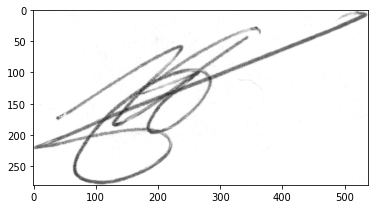

In [47]:
plt.imshow(reference_genuine_images[0])

In [63]:
def preprocess_data(array):
    resized_data = []
    for row in array:
        temp = resize_image(row)
        resized_data.append((temp))
    resized_data = np.array(resized_data)
    ref_binary = binarize_images(resized_data)
    ref_di = dilate_images(ref_binary)

    return ref_di

In [64]:
ref_processed = preprocess_data(reference_genuine_images)

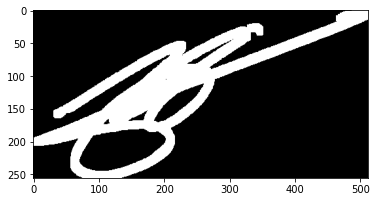

In [65]:
plt.imshow(ref_processed[0])

In [76]:
path = 'ICDAR/Testdata_SigComp2011/SigComp11-Offlinetestset/Dutch/Questioned(1287)/013'
count = 0
questioned_images = []
truth_values = []
for filename in os.listdir(path):
    if filename.endswith('.PNG') or filename.endswith('.png'):
        if len(filename) == 10:
            truth_values.append(1)
        else:
            truth_values.append(0)
        count += 1

        image = np.array(io.imread(path+'/'+filename, plugin='pil', as_gray=True))
        questioned_images.append(np.array(image))
print('# of images read in:',count)


# of images read in: 24


In [77]:
truth_values

[0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0]

In [78]:
questioned_processed = preprocess_data(questioned_images)

In [79]:
feature_table = compare_questioned_against_genuine(ref_processed, questioned_processed[0])

In [80]:
np.save('testing/test1_table', feature_table)

In [81]:
questioned_tables = []
for i, q in enumerate(questioned_processed):
    feature_table = compare_questioned_against_genuine(ref_processed, q)
    questioned_tables.append(np.array([i, feature_table, truth_values[i]]))

/var/folders/_b/x5pzbbjn11q03q6hjzl5jm980000gn/T/ipykernel_5186/2477589304.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  questioned_tables.append(np.array([i, feature_table, truth_values[i]]))


In [82]:
questioned_tables = np.array(questioned_tables)

In [83]:
np.save('testing/test013', questioned_tables)

In [84]:
st=time.time()
print('time', st)
for dir in questioned_dirs:
    print('time', st)
    path = 'ICDAR/Testdata_SigComp2011/SigComp11-Offlinetestset/Dutch/Questioned(1287)/'+dir
    count = 0
    questioned_images = []
    truth_values = []
    for filename in os.listdir(path):
        if filename.endswith('.PNG') or filename.endswith('.png'):
            if len(filename) == 10:
                truth_values.append(1)
            else:
                truth_values.append(0)
            count += 1

            image = np.array(io.imread(path+'/'+filename, plugin='pil', as_gray=True))
            questioned_images.append(np.array(image))
    print('# of images read in:',count)

    # np.save('testing/questioned_images_'+dir, questioned_images)

    questioned_processed = preprocess_data(questioned_images)

    np.save('testing/questions_processed_'+dir, questioned_processed)
    print("----%.2f----"%(time.time()-st))

time 1628750649.005053
time 1628750649.005053
# of images read in: 24


/Users/emilysluis/datamining/venv/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


----1.89----
time 1628750649.005053
# of images read in: 20
----3.13----
time 1628750649.005053
# of images read in: 24
----4.80----
time 1628750649.005053
# of images read in: 24
----5.87----
time 1628750649.005053
# of images read in: 20
----6.84----
time 1628750649.005053
# of images read in: 24
----8.38----
time 1628750649.005053
# of images read in: 28
----11.17----
time 1628750649.005053
# of images read in: 20
----12.36----
time 1628750649.005053
# of images read in: 24
----14.68----
time 1628750649.005053
# of images read in: 20
----15.74----
time 1628750649.005053
# of images read in: 24
----19.78----
time 1628750649.005053
# of images read in: 20
----22.82----
time 1628750649.005053
# of images read in: 24
----26.22----
time 1628750649.005053
# of images read in: 32
----28.84----
time 1628750649.005053
# of images read in: 28
----31.76----
time 1628750649.005053
# of images read in: 24
----33.29----
time 1628750649.005053
# of images read in: 24
----35.53----
time 1628750649.

In [85]:
len(questioned_dirs)

54

In [89]:
testing_dirs = os.listdir('testing')


In [93]:
st=time.time()
print('time', st)
for dir in reference_dirs:
    path = 'ICDAR/Testdata_SigComp2011/SigComp11-Offlinetestset/Dutch/Reference(646)/013'
    count = 0
    reference_genuine_images = []
    for filename in os.listdir(path):
        if filename.endswith('.PNG'):
            count += 1
            image = np.array(io.imread(path+'/'+filename, plugin='pil', as_gray=True))
            reference_genuine_images.append(np.array(image))

    print('# of images read in:',count)
    ref_processed = preprocess_data(reference_genuine_images)
    np.save('testing/ref_processes_'+dir, ref_processed)
    print("----%.2f----"%(time.time()-st))


time 1628751369.693569
# of images read in: 12
----1.07----
# of images read in: 12
----1.74----
# of images read in: 12
----2.82----
# of images read in: 12
----3.42----
# of images read in: 12
----4.00----
# of images read in: 12
----4.54----
# of images read in: 12
----5.02----
# of images read in: 12
----5.56----
# of images read in: 12
----6.49----
# of images read in: 12
----7.32----
# of images read in: 12
----8.12----
# of images read in: 12
----8.92----
# of images read in: 12
----9.70----
# of images read in: 12
----10.50----
# of images read in: 12
----11.26----
# of images read in: 12
----12.07----
# of images read in: 12
----12.88----
# of images read in: 12
----13.66----
# of images read in: 12
----14.41----
# of images read in: 12
----15.27----
# of images read in: 12
----16.01----
# of images read in: 12
----16.72----
# of images read in: 12
----17.40----
# of images read in: 12
----18.06----
# of images read in: 12
----18.82----
# of images read in: 12
----19.50----
# 

In [ ]:
st=time.time()
print('starting')
for j, dir in enumerate(testing_dirs):
    if dir.startswith('questions_processed'):
        print(dir, j)
        questioned_processed = np.load('testing/'+dir)
        ref_processed = np.load('testing/ref_processes_'+dir[-7:])

        questioned_tables = []
        for i, q in enumerate(questioned_processed):
            feature_table = compare_questioned_against_genuine(ref_processed, q)
            questioned_tables.append(np.array([i, feature_table], dtype=object))
            print("----%.2f----"%(time.time()-st))
        np.save('testing/test_table_'+str(j), questioned_tables)
        print("----%.2f----"%(time.time()-st))

starting
questions_processed_019.npy 3
----2.99----
----5.19----
----8.54----
----10.89----
----13.99----
----16.73----
----18.86----
----21.23----
----23.25----
----25.86----
----29.25----
----31.87----
----34.34----
----36.70----
----40.05----
----42.53----
----45.09----
----47.72----
----50.22----
----54.48----
----57.09----
----60.67----
----63.05----
----65.92----
----65.92----
questions_processed_025.npy 4
----71.43----
----77.31----
----83.67----
----88.71----
----94.94----
----101.04----
----106.27----
----111.08----
----117.10----
----121.98----
----128.53----
----134.55----
----140.93----
----147.39----
----151.58----
----157.35----
----162.84----
----167.54----
----173.90----
----179.21----
----179.21----
questions_processed_031.npy 5
----183.35----
----187.15----
----190.90----
----195.13----
----199.33----
----202.21----
----206.64----
----209.63----
----213.49----
----217.24----
----221.41----
----225.53----
----229.29----
----233.28----
----237.07----
----240.90----
----

KeyboardInterrupt: 

In [ ]:
testing_dirs